In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math



# --- 2. Corrected SGLD Optimizer ---
class SGLDOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, temperature=1.0):
        defaults = dict(lr=lr, temperature=temperature)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            T = group['temperature']
            noise_std = math.sqrt(2 * lr * T)

            for p in group['params']:
                if p.grad is None: continue
                
                # NNGP Prior Matching:
                # We want prior variance sigma^2 = 1/fan_in
                # In SGLD, weight decay lambda must be T / sigma^2
                # Therefore, weight_decay = T * fan_in
                fan_in = p.shape[1] if p.ndim > 1 else 1
                weight_decay = T * fan_in
                
                # Update: w = w - lr*(grad + wd*w) + noise
                d_p = p.grad + weight_decay * p
                p.add_(d_p, alpha=-lr)
                p.add_(torch.randn_like(p), alpha=noise_std)

# --- 3. Model and Data ---
class FCN2_ERF(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        # 2 hidden layers implies 3 weight matrices (W1, W2, W3)
        self.fc1 = nn.Linear(d, h, bias=False)
        self.fc2 = nn.Linear(h, h, bias=False)
        self.fc3 = nn.Linear(h, 1, bias=False)

    def forward(self, x):
        x = torch.erf(self.fc1(x))
        x = torch.erf(self.fc2(x))
        x = self.fc3(x)
        return x

# Generate Synthetic Data
D_IN = 10
P = 30 # Number of samples
torch.manual_seed(42)
X_train = torch.randn(P, D_IN)
Y_train = X_train[:, 0:1] #* 1.0  # Simple linear target

# --- 4. Training ---
HIDDEN = 2000
model = FCN2_ERF(D_IN, HIDDEN)
# Initialize weights with 1/fan_in variance to start near the prior
for p in model.parameters():
    fan_in = p.shape[1] if p.ndim > 1 else 1
    nn.init.normal_(p, std=math.sqrt(1.0/fan_in))

# Temperature 1.0 works well; reduction='sum' is required for SGLD logic
criterion = nn.MSELoss(reduction='sum')
optimizer = SGLDOptimizer(model.parameters(), lr=1e-5, temperature=1.0)

print("Training FCN2 via SGLD...")
epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = criterion(model(X_train), Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()/P:.4f}")


Training FCN2 via SGLD...
Epoch 0 | Loss: 1.7253
Epoch 5000 | Loss: 0.2240
Epoch 10000 | Loss: 0.2570
Epoch 15000 | Loss: 0.0820


In [30]:
[n for n,p in  model.named_parameters()]

['W0', 'A']

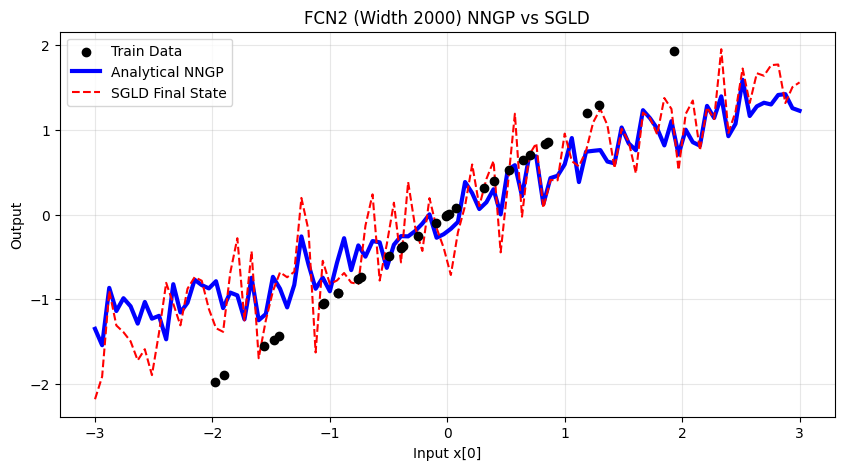

In [14]:

# --- 1. Analytical Arcsin NNGP Kernel (The Ground Truth) ---
def arcsin_step(K):
    """One layer of Arcsin (erf) NNGP kernel evolution."""
    diag = torch.sqrt(1 + 2 * torch.diagonal(K))
    denom = diag[:, None] * diag[None, :]
    arg = torch.clamp(2 * K / denom, -1.0, 1.0)
    return (2 / torch.pi) * torch.arcsin(arg)

def compute_nngp_prediction(X_train, Y_train, X_test):
    """
    Computes exact NNGP inference for FCN2.
    Matches the Arcsin kernel with sigma_w^2=1, sigma_b^2=0.
    """
    X_all = torch.cat([X_train, X_test], dim=0)
    d = X_all.shape[1]
    
    # Layer 0 (Input)
    K = (X_all @ X_all.T) / d
    # Layer 1 (Hidden 1)
    K = arcsin_step(K)
    # Layer 2 (Hidden 2)
    K = arcsin_step(K)
    
    # GP Inference: y_pred = K_test_train @ (K_train_train + noise*I)^-1 @ y_train
    # Note: SGLD samples the posterior. For NNGP, noise is usually small.
    P = len(Y_train)
    K_tt = K[:P, :P]
    K_xt = K[P:, :P]
    
    # Small epsilon for numerical stability
    L = torch.linalg.cholesky(K_tt + 0.5 * torch.eye(P))
    alpha = torch.cholesky_solve(Y_train, L)
    return K_xt @ alpha

    
# --- 5. Comparison and Plotting ---
X_test = torch.linspace(-3, 3, 100).view(-1, 1)
# Create test data with same background noise as training data
X_test_full = torch.randn(100, D_IN) # Background noise in all 10 dims
X_test_full[:, 0] = X_test.flatten() # Override the first dim with our sweep


# Analytical Prediction
y_nngp = compute_nngp_prediction(X_train, Y_train, X_test_full)

# Empirical Prediction (Average over multiple Langevin samples or one final)
model.eval()
with torch.no_grad():
    y_sgld = model(X_test_full)

plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], Y_train, color='black', label='Train Data', zorder=3)
plt.plot(X_test, y_nngp, label='Analytical NNGP', color='blue', linewidth=3)
plt.plot(X_test, y_sgld, label='SGLD Final State', color='red', linestyle='--')
plt.title(f"FCN2 (Width {HIDDEN}) NNGP vs SGLD")
plt.xlabel("Input x[0]")
plt.ylabel("Output")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training SGLD (T=0.02)...
Epoch 0 | Loss: 3.5491
Epoch 10000 | Loss: 0.0105
Epoch 20000 | Loss: 0.0159
Epoch 30000 | Loss: 0.0124
Epoch 40000 | Loss: 0.0129


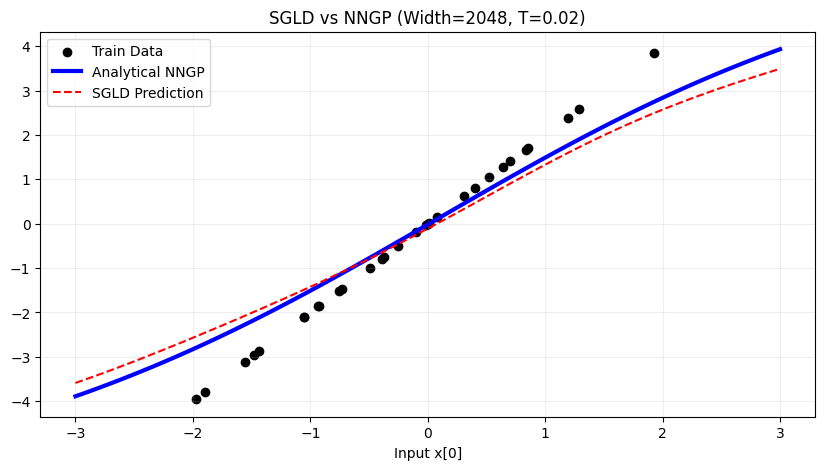

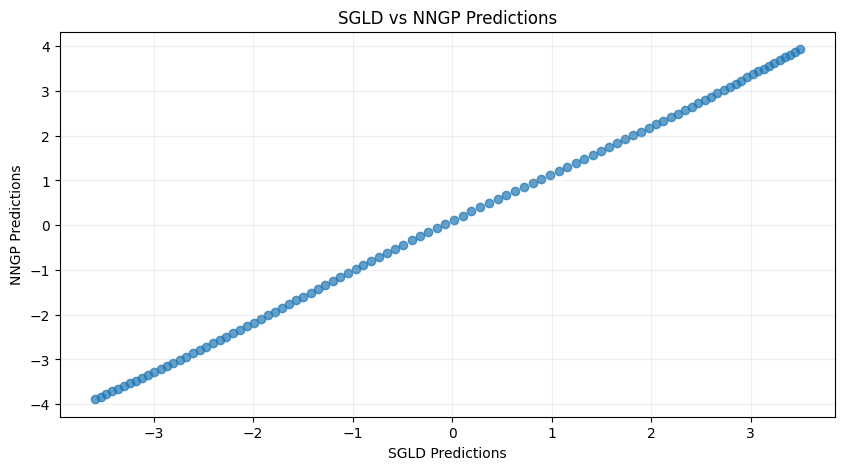

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from opt_einsum import contract

# --- 1. Your Model Implementation ---
class FCN2NetworkActivationGeneric(nn.Module):
    def __init__(self, d, n1, ens=1, activation="erf"):
        super().__init__()
        self.d, self.n1, self.ens = d, n1, ens
        self.activation_name = activation
        # Initialize with NNGP prior: var = 1/fan_in
        self.W0 = nn.Parameter(torch.empty(ens, n1, d).normal_(0.0, (1.0/d)**0.5))
        self.A = nn.Parameter(torch.empty(ens, n1).normal_(0.0, (1.0/n1)**0.5))

    def forward(self, X):
        # h0 = W0 @ X -> (P, ens, n1)
        h0 = contract('qkl,ul->uqk', self.W0, X)
        a0 = torch.erf(h0) if self.activation_name == "erf" else h0
        # output = A @ a0 -> (P, ens)
        return contract('qk,uqk->uq', self.A, a0)

# --- 2. Analytical NNGP Kernel (1-Layer Arcsin) ---
def compute_nngp_analytical(X_train, Y_train, X_test, temperature):
    d = X_train.shape[1]
    X_all = torch.cat([X_train, X_test], dim=0)
    
    # 1-Layer Arcsin Kernel
    Sigma = (X_all @ X_all.T) / d
    diag = torch.sqrt(1 + 2 * torch.diagonal(Sigma))
    denom = diag[:, None] * diag[None, :]
    K = (2 / np.pi) * torch.asin(torch.clamp(2 * Sigma / denom, -1.0, 1.0))
    
    # GP Inference
    P = len(Y_train)
    K_tt, K_xt = K[:P, :P], K[P:, :P]
    # Ridge (noise) = T / 2 for SGLD with sum-loss
    noise = (temperature / 2.0)
    L = torch.linalg.cholesky(K_tt + noise * torch.eye(P))
    alpha = torch.cholesky_solve(Y_train, L)
    return K_xt @ alpha

# --- 3. Setup Data and Hyperparams ---
d, n1, P, ens = 10, 2048, 30, 1
T, lr, epochs = 0.02, 1e-5, 50000

torch.manual_seed(42)
X_train = torch.randn(P, d)
Y_train = X_train[:, 0:1] * 2.0 # Simple signal

# Create Test Data (Fixed background noise to avoid wiggles)
X_test_axis = torch.linspace(-3, 3, 100).view(-1, 1)
X_test = torch.zeros(100, d) 
X_test[:, 1:] = torch.randn(1, d-1) # Same noise for all test points
X_test[:, 0:1] = X_test_axis

# --- 4. Langevin Training Loop ---
model = FCN2NetworkActivationGeneric(d, n1, ens=ens)
optimizer = torch.optim.SGD(model.parameters(), lr=lr) # We manually add noise

print(f"Training SGLD (T={T})...")
for epoch in range(epochs):
    optimizer.zero_grad()
    # Loss must be SUM of squares for SGLD mapping
    output = model(X_train)
    loss = torch.sum((output - Y_train)**2)
    loss.backward()
    
    # Langevin Step
    with torch.no_grad():
        for name, p in model.named_parameters():
            # Prior Weight Decay: wd = T / prior_variance
            wd = (T * d) if 'W0' in name else (T * n1)
            
            # Update: p = p - lr*(grad + wd*p) + sqrt(2*lr*T)*noise
            noise = torch.randn_like(p) * np.sqrt(2 * lr * T)
            p.add_(p.grad + wd * p, alpha=-lr)
            p.add_(noise)

    if epoch % 10000 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()/P:.4f}")

# --- 5. Comparison and Plotting ---
model.eval()
with torch.no_grad():
    y_sgld = model(X_test).numpy()
    y_nngp = compute_nngp_analytical(X_train, Y_train, X_test, T).numpy()

plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], Y_train, color='black', label='Train Data')
plt.plot(X_test_axis, y_nngp, color='blue', lw=3, label='Analytical NNGP')
plt.plot(X_test_axis, y_sgld, color='red', ls='--', label='SGLD Prediction')
plt.title(f"SGLD vs NNGP (Width={n1}, T={T})")
plt.xlabel("Input x[0]")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_sgld, y_nngp, alpha=0.7)
# plt.plot([-3, 3], [-3, 3], color='black', ls='--')
plt.title("SGLD vs NNGP Predictions")
plt.xlabel("SGLD Predictions")
plt.ylabel("NNGP Predictions")
plt.grid(True, alpha=0.2)
plt.show()

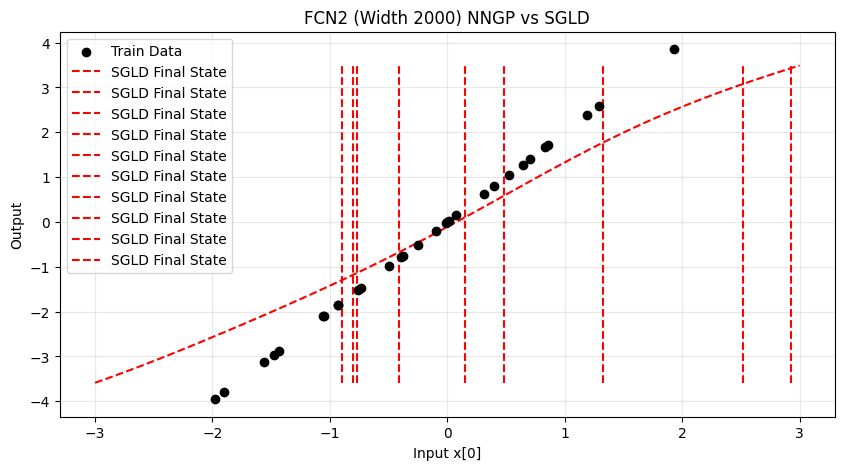

In [26]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], Y_train, color='black', label='Train Data', zorder=3)
# plt.plot(X_test, y_nngp, label='Analytical NNGP', color='blue', linewidth=3)

plt.plot(X_test, y_sgld, label='SGLD Final State', color='red', linestyle='--')
plt.title(f"FCN2 (Width {HIDDEN}) NNGP vs SGLD")
plt.xlabel("Input x[0]")
plt.ylabel("Output")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

# --- 1. SGLD Optimizer with Layer-Specific Chi Scaling ---
class SGLDOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, temperature=1.0, chi=1.0):
        defaults = dict(lr=lr, temperature=temperature, chi=chi)
        super().__init__(params, defaults)
        
        # We need to identify which parameter is the "final" one
        # In this specific script, it's the last one in the list
        self.param_list = list(params)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            T = group['temperature']
            chi = group['chi']
            
            t_eff = T / chi
            noise_std = math.sqrt(2 * lr * t_eff)

            for i, p in enumerate(group['params']):
                if p.grad is None: continue
                
                fan_in = p.shape[1] if p.ndim > 1 else 1
                
                # Apply the chi-dependent weight decay logic
                # Instruction: Final layer has an extra factor of chi
                is_final_layer = (i == len(group['params']) - 1)
                
                if is_final_layer:
                    # wd = fan_in * (T / chi) * chi = fan_in * T
                    weight_decay = fan_in * t_eff * chi
                else:
                    # wd = fan_in * (T / chi)
                    weight_decay = fan_in * t_eff
                
                # Langevin Update
                d_p = p.grad + weight_decay * p
                p.add_(d_p, alpha=-lr)
                p.add_(torch.randn_like(p), alpha=noise_std)

# --- 2. Model (FCN2 - 2 Hidden Layers) ---
class FCN2_ERF(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        # Layer 1: d -> h
        self.fc1 = nn.Linear(d, h, bias=False)
        # Layer 2: h -> h
        self.fc2 = nn.Linear(h, h, bias=False)
        # Final Layer: h -> 1
        self.fc3 = nn.Linear(h, 1, bias=False)

    def forward(self, x):
        x = torch.erf(self.fc1(x))
        x = torch.erf(self.fc2(x))
        x = self.fc3(x)
        return x

# --- 3. Analytical NNGP Kernel ---
def arcsin_step(K):
    diag = torch.sqrt(1 + 2 * torch.diagonal(K))
    denom = diag[:, None] * diag[None, :]
    arg = torch.clamp(2 * K / denom, -1.0, 1.0)
    return (2 / np.pi) * torch.asin(arg)

def compute_nngp(X_train, Y_train, X_test, T, chi):
    d = X_train.shape[1]
    X_all = torch.cat([X_train, X_test], dim=0)
    
    # Kernel Evolution
    K = (X_all @ X_all.T) / d
    K = arcsin_step(K)
    K = arcsin_step(K)
    
    P = len(Y_train)
    K_tt, K_xt = K[:P, :P], K[P:, :P]
    
    # Ridge/GP Noise = T_eff / 2 = T / (2 * chi)
    ridge = T / (2.0 * chi)
    
    L = torch.linalg.cholesky(K_tt + ridge * torch.eye(P))
    alpha = torch.cholesky_solve(Y_train, L)
    return K_xt @ alpha

# --- 4. Configuration and Training ---
D_IN, P, HIDDEN = 10, 30, 2000
T, CHI, LR = 0.02, 2000, 1e-5  
EPOCHS = 1_000_000

torch.manual_seed(42)
X_train = torch.randn(P, D_IN)
Y_train = X_train[:, 0:1] 

model = FCN2_ERF(D_IN, HIDDEN)
for p in model.parameters():
    fan_in = p.shape[1] if p.ndim > 1 else 1
    nn.init.normal_(p, std=(1.0/fan_in)**0.5)

# Pass model parameters to optimizer
optimizer = SGLDOptimizer(model.parameters(), lr=LR, temperature=T, chi=CHI)
criterion = nn.MSELoss(reduction='sum')

print(f"Training FCN2: T={T}, Chi={CHI}")
print(f"Final Layer WD will be {HIDDEN*T:.4f} (Effective T scaled by chi)")

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    loss = criterion(model(X_train), Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()/P:.4f}")

# --- 5. Visualization ---
X_test_axis = torch.linspace(-3, 3, 100).view(-1, 1)
X_test = torch.randn(100, D_IN) 
X_test[:, 0:1] = X_test_axis

y_nngp = compute_nngp(X_train, Y_train, X_test, T, CHI).detach().numpy()
model.eval()
y_model = model(X_test).detach().numpy()

plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], Y_train, color='black', label='Train Data')
plt.plot(X_test_axis, y_nngp, color='blue', lw=3, label=f'NNGP (Ridge={T/(2*CHI):.4f})')
plt.plot(X_test_axis, y_model, color='red', ls='--', label='SGLD Model')
plt.title(f"FCN2 with Final Layer Chi Scaling (Chi={CHI})")
plt.legend()
plt.show()

Training FCN2: T=0.02, Chi=2000
Final Layer WD will be 40.0000 (Effective T scaled by chi)
Epoch 0 | Loss: 1.7253
Epoch 5000 | Loss: 0.0010
Epoch 10000 | Loss: 0.0009
Epoch 15000 | Loss: 0.0008
Epoch 20000 | Loss: 0.0007
Epoch 25000 | Loss: 0.0007
Epoch 30000 | Loss: 0.0006
Epoch 35000 | Loss: 0.0006
Epoch 40000 | Loss: 0.0006
Epoch 45000 | Loss: 0.0005
Epoch 50000 | Loss: 0.0005
Epoch 55000 | Loss: 0.0004
Epoch 60000 | Loss: 0.0004
Epoch 65000 | Loss: 0.0004
Epoch 70000 | Loss: 0.0004
Epoch 75000 | Loss: 0.0004
Epoch 80000 | Loss: 0.0004
Epoch 85000 | Loss: 0.0004
Epoch 90000 | Loss: 0.0003
Epoch 95000 | Loss: 0.0004
Epoch 100000 | Loss: 0.0003
Epoch 105000 | Loss: 0.0003
Epoch 110000 | Loss: 0.0003
Epoch 115000 | Loss: 0.0003
Epoch 120000 | Loss: 0.0003
Epoch 125000 | Loss: 0.0002
Epoch 130000 | Loss: 0.0003
Epoch 135000 | Loss: 0.0003
Epoch 140000 | Loss: 0.0003
Epoch 145000 | Loss: 0.0002
Epoch 150000 | Loss: 0.0002
Epoch 155000 | Loss: 0.0002
Epoch 160000 | Loss: 0.0002
Epoch 1650

KeyboardInterrupt: 

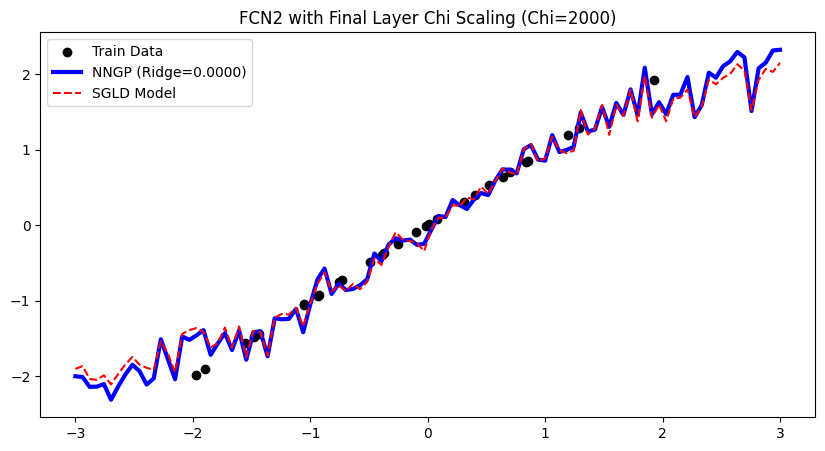

In [32]:

# --- 5. Visualization ---
X_test_axis = torch.linspace(-3, 3, 100).view(-1, 1)
X_test = torch.randn(100, D_IN) 
X_test[:, 0:1] = X_test_axis

y_nngp = compute_nngp(X_train, Y_train, X_test, T, CHI).detach().numpy()
model.eval()
y_model = model(X_test).detach().numpy()

plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], Y_train, color='black', label='Train Data')
plt.plot(X_test_axis, y_nngp, color='blue', lw=3, label=f'NNGP (Ridge={T/(2*CHI):.4f})')
plt.plot(X_test_axis, y_model, color='red', ls='--', label='SGLD Model')
plt.title(f"FCN2 with Final Layer Chi Scaling (Chi={CHI})")
plt.legend()
plt.show()

In [33]:
model.H_eig()

AttributeError: 'FCN2_ERF' object has no attribute 'H_eig'

In [ ]:
#